In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

%matplotlib inline
%pylab inline 

from scipy.optimize import minimize

import logiticModel as lm

import itertools

Populating the interactive namespace from numpy and matplotlib


OBS:
    
    -> The convergence towards the minima is very sensite to initial parameters 

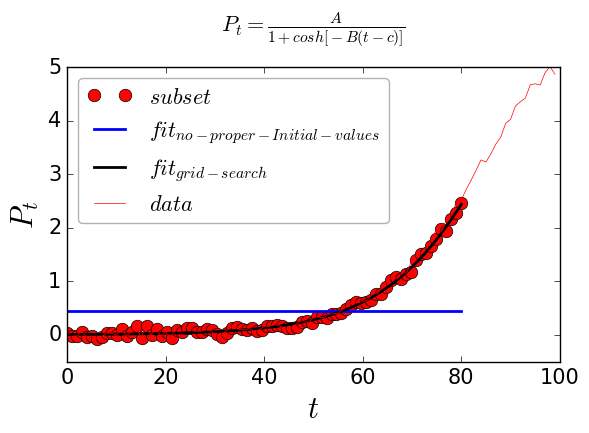

In [151]:
lm = reload(lm)
# Generate synthetic time-series
pars = 10., .8, 5.25
sdata = lm.hubbertModel_Simulate(pars, T=100, errorLevel=0.05)

y1, y2 = 0, 80

# Fit without being interested on initial values
res = lm.fitModel(sdata[y1:y2])
fit = lm.hubbertModel_Simulate(res.x, T=100, errorLevel=0.0)

# Fitting with being interested
fitRight, _ = lm.fitNlinears(sdata[y1:y2])
fitR = lm.hubbertModel_Simulate(fitRight, T=100, errorLevel=0.0)

# Plot rest
f,ax = plt.subplots(1,1,figsize=(6,4.5))
plt.plot(np.linspace(y1,y2,len(sdata[y1:y2])), sdata[y1:y2], marker='o',
         linestyle='', alpha=0.99, linewidth=2, color='r', markersize=9)
plt.plot(np.linspace(y1,y2,len(fit)), fit, linewidth=2, color='b')
plt.plot(np.linspace(y1,y2,len(fitR)), fitR, linewidth=2, color='k')
plt.plot(sdata, linewidth=.5, color='r')
plt.legend(['$subset$','$fit_{no-proper-Initial-values}$','$fit_{grid-search}$','$data$'],
          loc='best', fontsize=16, fancybox=True, framealpha=0.3)
plt.xlabel('$t$', fontsize=22)
plt.ylabel('$P_t$', fontsize=22)
plt.title(r'$P_t = \frac{A}{1+cosh[-B(t-c)]}$', y=1.1, fontsize=16)
plt.ylim([-.5, 5])
plt.tight_layout()

### Sloppy analysis:

A is very sloppy, followed by C and B (rigid)

In [3]:
lm = reload(lm)
H = lm.obtainHessian(fitRight, sdata[y1:y2])
E,V = np.linalg.eigh(H)

In [4]:
pd.DataFrame(V, index=E, columns=['A','B','C'])

,A,B,C
0.000302,0.982742,-0.183928,0.019742
1.157153,-0.005567,-0.136080,-0.990682
1395.967929,0.184900,0.973475,-0.134755


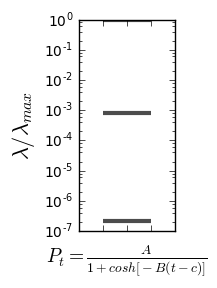

In [5]:
f,ax = plt.subplots(1,1,figsize=(2,3), sharey=True)
plt.eventplot(E/max(E), orientation='vertical', linewidth=3, color='k', alpha=.7)
ax.set_yscale('log')
ax.set_ylabel(r'$\lambda/\lambda_{max}$', fontsize=16)
ax.set_xticklabels('')
ax.set_xlabel(r'$P_t = \frac{A}{1+cosh[-B(t-c)]}$', fontsize=14)
plt.tight_layout()

## Profilling 

In [6]:
lm = reload(lm)

In [7]:
# Estimate the Profile for all parameters
lpA, lpB, lpC = lm.profile_logistic(sdata[y1:y2], A=False, B=False, C=False, Alles=True)

logiticModel.py:139: RuntimeWarning: overflow encountered in cosh
  model[t] = A / (1.+np.cosh(-B*(grid[t]-C)))
logiticModel.py:179: RuntimeWarning: overflow encountered in cosh
  model[t] = A / (1.+np.cosh(-B*(grid[t]-C)))
logiticModel.py:159: RuntimeWarning: overflow encountered in cosh
  model[t] = A / (1.+np.cosh(-B*(grid[t]-C)))


In [8]:
# Create grid and iterate
Agrid = np.linspace(0.1, 20, 80)

In [9]:
parA = pd.DataFrame(lpA, index=Agrid)
parB = pd.DataFrame(lpB, index=Agrid)
parC = pd.DataFrame(lpC, index=Agrid)

bestA = parA[parA == parA.min()[0]].dropna().index[0]
bestB = parB[parB == parB.min()[0]].dropna().index[0]
bestC = parC[parC == parC.min()[0]].dropna().index[0]

print('True pars:                          A = %.2f, B = %.2f, C = %.2f'%(pars[0], pars[1], pars[2]))
print('Estimated parameters via Lp:        A = %.2f,  B = %.2f, C = %.2f'%(bestA, bestB, bestC))
print('Estimated parameters via min(SSR):  A = %.2f,  B = %.2f, C = %.2f'%(fitRight[0],
                                                                          fitRight[1],
                                                                          fitRight[2]))

True pars:                          A = 10.00, B = 0.80, C = 5.25
Estimated parameters via Lp:        A = 12.69,  B = 0.60, C = 8.41
Estimated parameters via min(SSR):  A = 12.72,  B = 0.62, C = 8.42


In [121]:
Agrid = np.linspace(0.1, 20, 80)

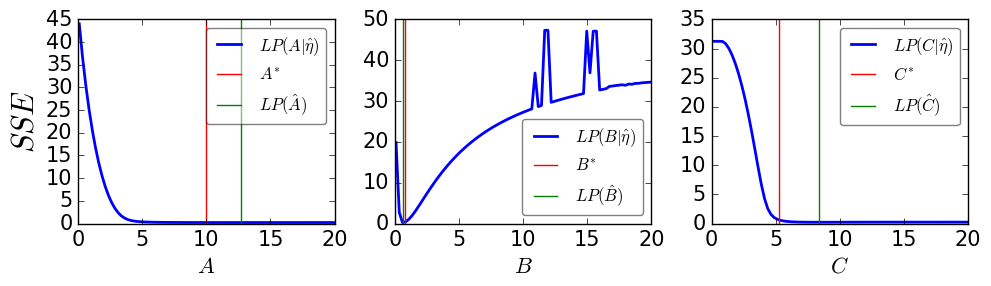

In [128]:
f,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(Agrid, lpA, linewidth=2)
ax[0].axvline(pars[0], color='r')
ax[0].axvline(bestA, color='g')
ax[1].plot(Agrid, lpB, linewidth=2)
ax[1].axvline(pars[1], color='r')
ax[1].axvline(bestB, color='g')
ax[2].plot(Agrid, lpC, linewidth=2)
ax[2].axvline(pars[2], color='r')
ax[2].axvline(bestC, color='g')
ax[0].set_ylabel(r'$SSE$', fontsize=22)

ax[0].legend(['$LP(A|\hat{\eta})$', '$A^{*}$','$LP(\hat{A})$'],
            fancybox=True, framealpha=0.5, loc='best')

ax[1].legend(['$LP(B|\hat{\eta})$', '$B^{*}$','$LP(\hat{B})$'],
            fancybox=True, framealpha=0.5, loc='best')

ax[2].legend(['$LP(C|\hat{\eta})$', '$C^{*}$','$LP(\hat{C})$'],
            fancybox=True, framealpha=0.5, loc='best')

ax[0].set_xlabel(r'$A$', fontsize=16)
ax[1].set_xlabel(r'$B$', fontsize=16)
ax[2].set_xlabel(r'$C$', fontsize=16)

plt.tight_layout()
#plt.savefig('/Users/demos/Desktop/LProfile.pdf')

# Modified Profile Likelihood

In [15]:
lm = reload(lm)
test = lm.modProfLikelihoodA(sdata)

logiticModel.py:140: RuntimeWarning: overflow encountered in cosh
  
logiticModel.py:48: RuntimeWarning: overflow encountered in cosh
  
logiticModel.py:412: RuntimeWarning: overflow encountered in cosh
  
logiticModel.py:30: RuntimeWarning: overflow encountered in cosh
  
logiticModel.py:430: RuntimeWarning: divide by zero encountered in log
  
//anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
//anaconda/lib/python2.7/site-packages/numdifftools/step_generators.py:102: RuntimeWarning: invalid value encountered in greater
  if (np.abs(step) > 0).all():
//anaconda/lib/python2.7/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
logiticModel.py:430: RuntimeWarning: invalid value encountered in double_scalars
  


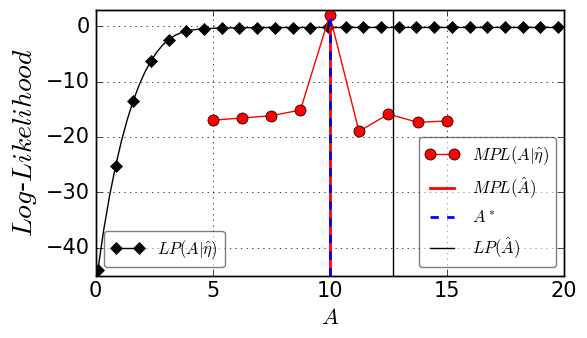

In [119]:

f,ax = plt.subplots(1,1,figsize=(6,3.5))
plt.plot(np.linspace(0.1, 20, 80), -np.array(lpA), linewidth=1, marker='D',
        markevery=3, color='k')
plt.legend([r'$LP(A|\hat{\eta})$'], loc='lower left', framealpha=0.5, fancybox=True)
plt.grid()
plt.xlabel(r'$A$', fontsize=16)
plt.ylabel(r'$Log$-$Likelihood$', fontsize=20)
plt.ylim([-45, 3])
ax = plt.twinx()
ax.plot(np.linspace(5, 15, 9), -np.array(test), linewidth=1, color='r', marker='o',
       markersize=8)
ax.set_ylim([-45, 3])
ax.set_yticklabels('')
ax.axvline(pars[0], color='r', linestyle='-', linewidth=2)
ax.axvline(pars[0], color='b', linestyle='--', linewidth=2)
ax.axvline(bestA, color='k', linewidth=1)
plt.legend(['$MPL(A|\hat{\eta})$','$MPL(\hat{A})$','$A^*$','$LP(\hat{A})$'],
           loc='lower right', framealpha=0.5, fancybox=True)
plt.tight_layout()
#plt.savefig('/Users/demos/Desktop/hubpdf.pdf')

# Monte-Carlo